# Analysis



In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2, venn3

try: 
    # for notebook
    get_ipython
    from tqdm._tqdm_notebook import tqdm_notebook as tqdm  
except: 
    # for commandline
    from tqdm import tqdm 
tqdm.pandas()

pd.set_option("display.precision", 2)

In [2]:
sns.set_style("darkgrid")

In [3]:
input_csv = "../data/plos.csv"
urls_csv = "../data/urls.csv"
query_csv = "../data/queries.csv"
og_csv = "../data/og_objects.csv"
altmetric_csv = "../data/altmetric.csv"

### Prepare facebook datasets

In [4]:
articles = pd.read_csv(input_csv, index_col="doi", parse_dates=['publication_date'])
urls = pd.read_csv(urls_csv, index_col="url_id", parse_dates=['added_on'])
queries = pd.read_csv(query_csv, index_col="query_id", parse_dates=['queried_at'])
og_objects = pd.read_csv(og_csv, parse_dates=['og_updated_time', 'received_at'])

In [5]:
num_cols = ['reactions', 'shares', 'comments', 'plugin_comments']
og_objects[num_cols] = og_objects[num_cols].astype(int)

In [6]:
a = og_objects.merge(queries, left_on="query_id", right_index=True, how="left")
b = a.merge(urls, left_on="url_id", right_index=True, how="left")
c = b.merge(articles, left_on="doi", right_index=True, how="left")

### Prepare Altmetric data

In [7]:
def extract_metrics(row):
    try:
        resp = json.loads(row['am_resp'])
        medias = resp['counts'].keys()
        for media in medias:
            if 'posts_count' in resp['counts'][media]:
                row[media] = resp['counts'][media]['posts_count']
    except:
        return row
    
    return row

am_raw = pd.read_csv(altmetric_csv, index_col="doi")
am = am_raw.progress_apply(extract_metrics, axis=1)
del am['am_resp']
del am['am_err']
del am['shares']
del am['ts']

In [8]:
metrics = am

x = ['shares', 'comments', 'reactions']
for _ in x:
    metrics[_] = c.reset_index().groupby(["doi", "og_id"]).first().groupby(["doi"]).sum()[_]
    metrics[_+">0"] = metrics[_][metrics[_] != 0]

metrics['diff'] = metrics['shares'] - metrics.facebook
metrics['diff>0'] = metrics['shares>0'] - metrics.facebook
metrics.describe()

# metrics.to_csv("../data/metrics.csv")

,blogs,f1000,facebook,googleplus,news,patent,peer_reviews,policy,q&a,reddit,...,video,wikipedia,shares,shares>0,comments,comments>0,reactions,reactions>0,diff,diff>0
count,1307.00,126.00,3202.00,693.00,2203.00,40.00,88.00,155.00,7.0,3110.00,...,77.00,302.00,15349.00,6808.00,15349.00,3066.00,15349.00,4271.00,2856.00,2407.00
mean,1.99,1.03,2.33,2.47,6.79,1.25,1.86,1.26,1.0,1.08,...,1.70,1.69,3.43,7.73,4.42,22.15,13.53,48.62,12.32,14.84
std,2.33,0.18,4.27,6.37,44.48,0.54,1.61,0.76,0.0,0.53,...,2.49,2.10,45.51,68.09,81.98,182.37,119.25,222.27,102.27,111.22
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,...,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,-24.00,-24.00
25%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,...,1.00,1.00,0.00,1.00,0.00,2.00,0.00,4.00,0.00,0.00
50%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,...,1.00,1.00,0.00,2.00,0.00,6.00,0.00,16.00,1.00,2.00
75%,2.00,1.00,2.00,2.00,4.00,1.00,2.00,1.00,1.0,1.00,...,1.00,1.75,1.00,4.00,0.00,15.00,1.00,48.00,6.00,7.00
max,30.00,2.00,79.00,125.00,1999.00,3.00,9.00,7.00,1.0,16.00,...,16.00,24.00,4181.00,4181.00,7916.00,7916.00,10736.00,10736.00,4157.00,4157.00


## Statistics about link distribution and sharing

In [40]:
# Link types that were shared once at least
type_count = c.type.value_counts()
types = pd.concat([type_count, (type_count/type_count.sum()*100).astype(object)], axis=1)
types.columns = ["n", "%"]
types

,n,%
landing,15279,76
doi_old,2131,11
metrics,1417,7
pdf,830,4.1
doi,287,1.4
authors,136,0.67
related,46,0.23
comments,32,0.16


### Open Graph IDs per article

In [41]:
diff_ogids = c.reset_index().groupby(
    ["doi", "og_id"]).size().groupby(['doi']).count()
temp = diff_ogids.value_counts()
df = pd.concat([temp, (temp/temp.sum()*100).astype(object)], axis=1)
df.columns = ["n", "%"]
df

,n,%
1,14545,95
2,797,5.2
3,6,0.039
4,1,0.0065


### Numbers of links that were shared per article

In [42]:
# How many different links were shared per article
diff_links = c.reset_index().groupby(["doi"])['og_id'].size()
temp = diff_links.value_counts()
df = pd.concat([temp, (temp/temp.sum()*100).astype(object)], axis=1)
df.columns = ["n", "%"]
df

,n,%
1,11295,74
2,3445,22
3,503,3.3
4,82,0.53
5,14,0.091
6,5,0.033
7,4,0.026
8,1,0.0065


## Coverage

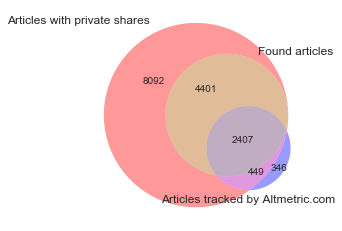

In [15]:
am_set = set(metrics['facebook'].dropna().index.tolist())
shares_set = set(metrics['shares'].dropna().index.tolist())
all_shares_set = set(metrics['shares>0'].dropna().index.tolist())

venn3([shares_set, all_shares_set, am_set], set_labels=('Articles with private shares', 'Found articles', 'Articles tracked by Altmetric.com'));

# plt.figure()
# venn2([fb_set, am_set], set_labels=('Found articles', 'Altmetric.com'))

> "As a consequence of this, it is not possible to be sure that articles with zero values for an altmetric should not have positive scores (unlike [42] for example). It is  ore certain that articles with a positive score on an altmetric had their data effectively collected with that altmetric and so data for articles with non-zero altmetric scores is the most reliable and is the only data used in this article." (Thelwall, Haustein, Larivière, & Sugimoto, 2013, p.3)

In [30]:
def remove_outliers(diff):
    # Remove outliers beyond Q3+1.5*IQR
    Q1 = diff.quantile(0.25)
    Q3 = diff.quantile(0.75)
    IQR = Q3 - Q1
    y_max = Q3 + 1.5 * IQR
    y_min = Q1 - 1.5 * IQR
    print(y_min, y_max)
    diff[diff <= y_min] = np.nan
    diff[diff >= y_max] = np.nan
    return diff


def simple_outliers(diff):
    diff[diff >= 72] = np.nan
    diff[diff <= -24] = np.nan
    return diff


s['diff_no'] = simple_outliers(s['diff'].copy())
print("Removed {} outliers".format(
    s['diff'].notnull().sum() - s['diff_no'].notnull().sum()))

s['diff_fillna_no'] = simple_outliers(s['diff_fillna'].copy())
print("Removed {} outliers".format(
    s['diff_fillna'].notnull().sum() - s['diff_fillna_no'].notnull().sum()))

Removed 68 outliers
Removed 72 outliers


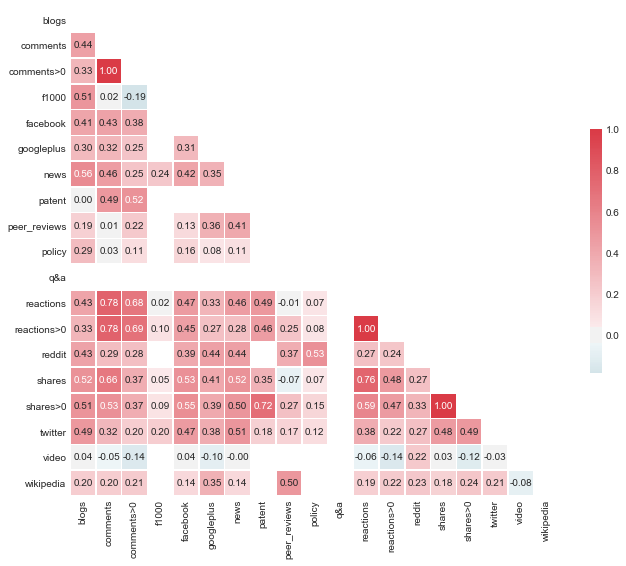

In [17]:
# Compute the correlation matrix
corr = metrics[metrics.columns.difference(['total', 'diff'])].corr(method="spearman")

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

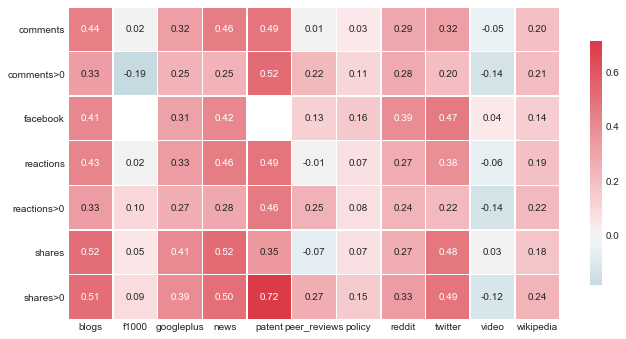

In [21]:
# Compute the correlation matrix
corr = metrics[metrics.columns.difference(['total', 'diff', 'q&a'])].corr(method="spearman")
corr = corr.loc[x+[_+">0" for _ in x]+['facebook']][corr.columns.difference(x+[_+">0" for _ in x]+['facebook'])]
corr = corr.sort_index()

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
#   mask = np.zeros_like(corr, dtype=np.bool)
#   mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

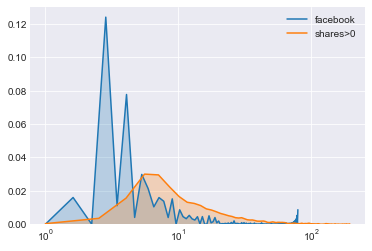

In [230]:
sns.kdeplot(t['facebook'].dropna(), clip=(0,200), shade=True, cut=0)
sns.kdeplot(t['shares>0'].dropna(), clip=(0,200), shade=True, cut=0)

plt.xscale("log")
# plt.yscale("log")

In [274]:
100*len(t[t['shares>0']>t['facebook']])/len(t)

68.25924387203989

In [277]:
(diff>0).sum(), (diff==0).sum(), (diff<0).sum()

(1643, 606, 158)

In [288]:
t['diff'] = t['shares>0'] - t['facebook']
def foo(x):
    if x < 0:
        return "alt"
    if x > 0:
        return "ours"
t['type'] = t['diff'].map(lambda x: foo(x))

(0, 15)

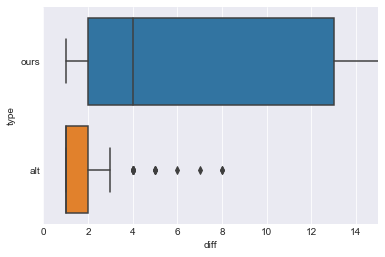

In [322]:
pdf = t[t.type.notnull()].copy()
pdf['diff'] = pdf['diff'].abs()
pdf = pdf[pdf['diff']<1000]
sns.boxplot(x="diff", y="type", data=pdf)
plt.xlim(0, 15)

In [283]:
t['shares>0'].loc[diff[diff==0].keys()].value_counts()

1.0    508
2.0     75
3.0     16
4.0      4
5.0      2
6.0      1
Name: shares>0, dtype: int64

In [278]:
diff[diff<0].describe()

count    158.00
mean      -1.85
std        2.23
min      -24.00
25%       -2.00
50%       -1.00
75%       -1.00
max       -1.00
dtype: float64

(0, 30)

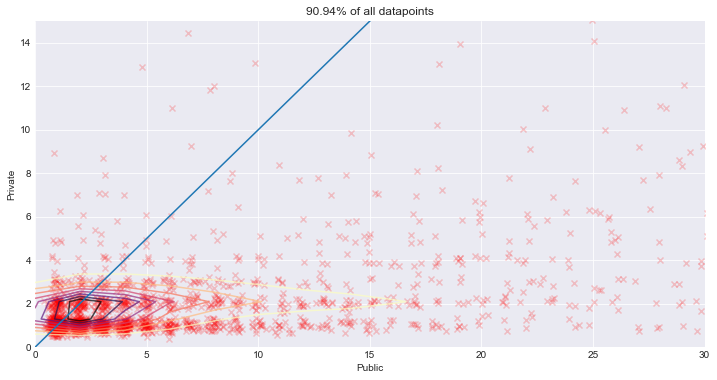

In [39]:
x,y = (30, 15)
h = 6
plt.figure(figsize=(h*(x/y),h))

t = metrics[['facebook', 'shares>0', 'diff']].dropna()
# t = t[t['diff']!=0]
sns.kdeplot(t['shares>0'], t['facebook'], clip=(0,200), cmap='magma_r', alpha=.7)
v,w = t['shares>0'] + np.random.normal(0,.2,len(t)), t['facebook'] + np.random.normal(0,.2,len(t))
plt.scatter(v, w, marker='x', color='r', alpha=0.2)
plt.plot(range(0,1000))
plt.ylabel('Private')
plt.xlabel('Public')

s = t[(t['shares>0']<=x) & (t['facebook']<=y)]

plt.title("{:.2f}% of all datapoints".format(100*len(s)/len(t)))

plt.ylim(0,y)
plt.xlim(0,x)
# plt.yscale("log")
# plt.xscale("log")

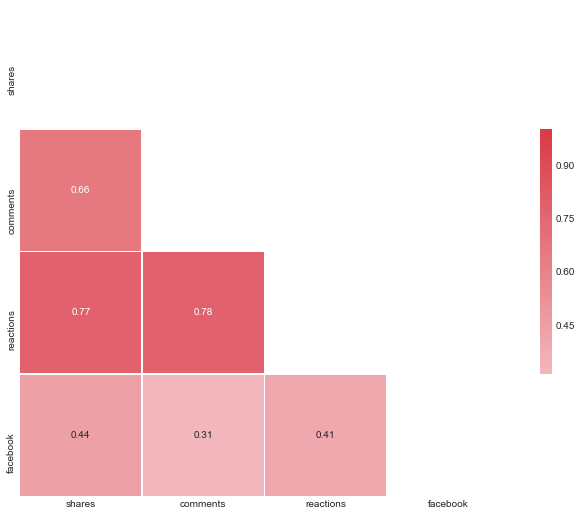

In [183]:
# Compute the correlation matrix

corr = metrics[x+['facebook']].fillna(0).corr(method="spearman")

# Draw the heatmap with the mask and correct aspect ratio
with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

(-80, 100)

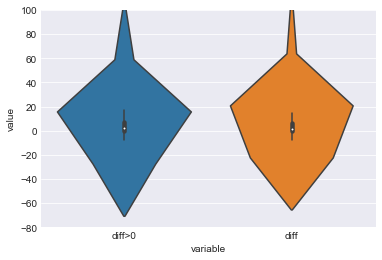

In [52]:
pdf = metrics[['diff>0', 'diff']].melt().dropna()
sns.violinplot(y="value", x="variable", data=pdf, split=True);
plt.ylim(-80, 100)

(-80, 150)

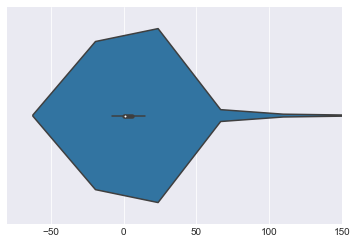

In [36]:
sns.violinplot(, split=True)
plt.xlim(-80, 150)

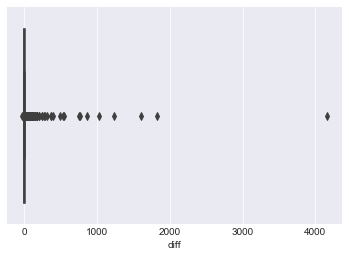

In [31]:
sns.boxplot(diff)

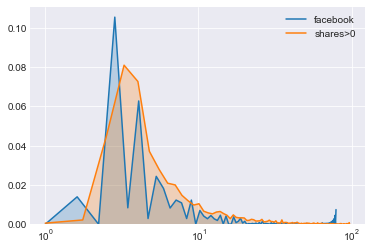

In [180]:
sns.kdeplot(metrics['facebook'].dropna(), clip=(0,100), shade=True, cut=0)
sns.kdeplot(metrics['shares>0'].dropna(), clip=(0,100), shade=True, cut=0)

plt.xscale("log")
# plt.yscale("log")

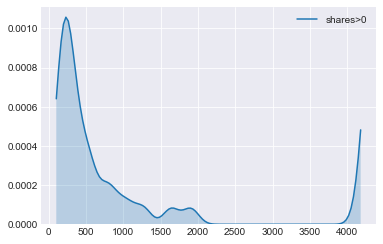

In [171]:
sns.kdeplot(metrics['shares>0'].dropna(), clip=(100,5000), shade=True, cut=0)

(-80, 100)

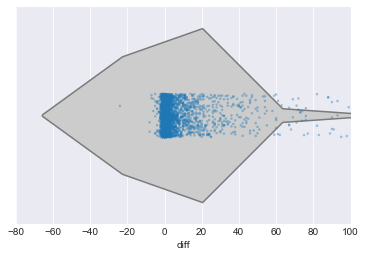

In [69]:
#ax = sns.distplot(diff, hist=False, norm_hist=True);
d = metrics['diff'].dropna()
ax = sns.violinplot(metrics['diff'], inner=None, color=".8")
# ax = sns.stripplot(x=diff, jitter=True, alpha=.25)
ax = sns.stripplot(metrics['diff'], size=2.5, jitter=True, alpha=.4)
plt.xlim(-80, 100)

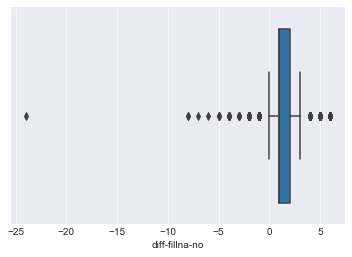

In [96]:
#ax = sns.distplot(diff, hist=False, norm_hist=True);
ax = sns.boxplot(diff)
# ax = sns.stripplot(x=diff, jitter=True, alpha=.25)
# ax = sns.swarmplot(diff, size=2)

In [55]:
pdf = s.melt(value_vars=["fb", "am"], var_name="source")

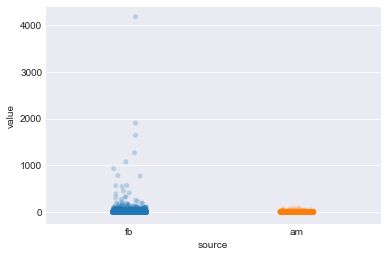

In [56]:
sns.stripplot(x="source", y="value", data=pdf, jitter=True, alpha=.25)

## Others

In [113]:
a = c.reset_index().groupby(["type", "og_id"])[['shares']].first().groupby(["type"]).mean()
a['mean'] = c.reset_index().groupby(["type", "og_id"])['shares'].first().groupby(["type"]).median()
a['n'] = c.reset_index().groupby(["type", "og_id"]).first().groupby(["type"]).size()
a

,shares,mean,n
type,,,
authors,80.794118,4.0,136
comments,334.656250,28.5,32
doi,42.264808,3.0,287
doi_old,17.822066,3.0,2130
landing,3.415930,0.0,15279
metrics,7.889753,0.0,1415
pdf,0.324487,0.0,829
related,189.760870,3.0,46
